In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import ImageOps
from IPython.display import Image, display
from osgeo import gdal, osr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img
from keras.callbacks import History 

# Build model

In [2]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)   
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)   
    return act2
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)   
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)   
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)   
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)
    model = Model(input1, out)
    return model
input_shape = (256, 256, 3)
model = U_Net(input_shape)

### Summary of model

In [3]:
input_shape = (256, 256, 3)
model = U_Net(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

 ormalization)                  )                                                                 
                                                                                                  
 re_lu_26 (ReLU)                (None, 16, 16, 1024  0           ['batch_normalization_26[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 1024  9438208     ['re_lu_26[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 16, 16, 1024  4096       ['conv2d_28[0][0]']              
 ormalization)                  )                                                                 
          

                                                                                                  
 conv2d_35 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 256, 256, 64  256        ['conv2d_35[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 re_lu_34 (ReLU)                (None, 256, 256, 64  0           ['batch_normalization_34[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_36

# Define input data

In [4]:
input_dir = r"C:\Users\Professional\Desktop\Dissertation\Proc\Images\Libya\Set\Cut\img_png"
target_dir = r"C:\Users\Professional\Desktop\Dissertation\Proc\Images\Libya\Set\Cut\mask_png"
img_size = (256, 256)
num_classes = 2
batch_size = 4

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
                          if fname.endswith(".png")])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) 
                           if fname.endswith(".png")])

### Display data

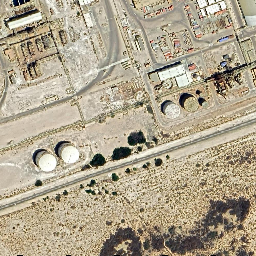

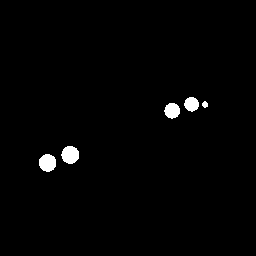

In [5]:
# Display input image #10
display(Image(filename=input_img_paths[10]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[10]))
display(img)

### Prepare x,y for train and validation set

In [6]:
class OilTanks(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

### Shuffle to train and validation set

In [7]:
# Split our img paths into a training and a validation set
val_samples = 24
random.Random(val_samples).shuffle(input_img_paths)
random.Random(val_samples).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


# Instantiate data Sequences for each split
train_gen = OilTanks(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OilTanks(batch_size, img_size, val_input_img_paths, val_target_img_paths)

print(f'Train data:\n{train_target_img_paths}\n')
print(f'Validation data:\n{val_target_img_paths}')

Train data:
['C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\91.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\74.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\146.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\85.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\83.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\3.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\24.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\9.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\122.png', 'C:\\Users\\Professional\\Desktop\\Dissertation\\Proc\\Images\\Libya\\Set\\Cut\\mask_png\\72.png

# Fit model

In [8]:
model.compile(optimizer="Adam", 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint("OilTanks_segmentation_v13_8.h5", save_best_only=True)]
epochs = 8
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
val_gen = OilTanks(batch_size, img_size, val_input_img_paths, val_target_img_paths)

Epoch 1/8
35/35 [==============================] - 1043s 30s/step - loss: 0.0487 - precision: 0.3875 - recall: 0.3550 - val_loss: 0.9686 - val_precision: 0.0314 - val_recall: 1.0000
Epoch 2/8
35/35 [==============================] - 1012s 29s/step - loss: 0.0276 - precision: 0.7054 - recall: 0.3264 - val_loss: 0.9686 - val_precision: 0.0314 - val_recall: 1.0000
Epoch 3/8
35/35 [==============================] - 988s 28s/step - loss: 0.0206 - precision: 0.7530 - recall: 0.5304 - val_loss: 0.9602 - val_precision: 0.0316 - val_recall: 1.0000
Epoch 4/8
35/35 [==============================] - 988s 28s/step - loss: 0.0159 - precision: 0.8200 - recall: 0.6185 - val_loss: 0.8637 - val_precision: 0.0335 - val_recall: 0.9988
Epoch 5/8
35/35 [==============================] - 961s 28s/step - loss: 0.0113 - precision: 0.8741 - recall: 0.7410 - val_loss: 0.2838 - val_precision: 0.0710 - val_recall: 0.9881
Epoch 6/8
35/35 [==============================] - 843s 24s/step - loss: 0.0091 - precision: 